### Model Set-Up

In [1]:
#@title Loading Functions

import base64
import matplotlib.pyplot as plt
from IPython.display import display, HTML

import numpy as np
from scipy.integrate import odeint


# define TMA_PMMA model
class TMA_PMMA(object):
    """
    C + B -> S
    """
    
    def __init__(self, params):
        self.l = params['l'] * 2
        self.df = params['D0']
        self.sc = params['C0surface']
        self.pc = params['C0polymer']
        self.hd = params['Kprime']
        self.k = params['k']
    
    def fpde(self, state, t):
        # obtain state information
        C = state[:self.xlim]
        S = state[self.xlim:(2*self.xlim)]
        B = state[(2*self.xlim):(3*self.xlim)]
        # compute boundary condition
        bdC = self.sc if (t <= self.st) else max(0, self.sc * (1-(t-self.st)/60))
        # compute time derivative
        fluxC = np.diff(np.concatenate(([bdC],C,[bdC]))) / np.concatenate(([self.dx/2],np.repeat(self.dx,self.xlim-1),[self.dx/2]))
        dCdt = self.df * np.exp(-self.hd * S) * np.diff(fluxC)/self.dx - self.k * C * B
        dSdt = self.k * C * B
        dBdt = -self.k * C * B
        return np.concatenate((dCdt,dSdt,dBdt))

    def init_states(self, xlim = 1000):
        self.xlim = xlim
        self.dx = self.l / (self.xlim + 1)
        C = np.zeros(xlim)
        S = np.zeros(xlim)
        B = np.repeat(self.pc, xlim)
        return np.concatenate((C,S,B))

    def init_times(self, timepoints):
        # timepoints = (sorption_time (st), desorption_time (dt))
        self.st, self.dt = timepoints
        sorption_times = np.linspace(0, min(self.st,5000), 2001) # 2.5 seconds interval for first 5000 seconds
        if (self.st > 5025):
            steps = (self.st-5000-1)//25 # 25 seconds interval after 5000 seconds
            sorption_times = np.concatenate((sorption_times, np.linspace(5025,5025+(steps-1)*25,steps)))
        desorption_times = np.linspace(0, min(self.dt,5000), 2001) # 2.5 seconds interval for first 5000 seconds
        if (self.dt > 5000):
            steps = (self.dt-5000-1)//25 # 25 seconds interval after 5000 seconds
            desorption_times = np.concatenate((desorption_times, np.linspace(5025,5025+(steps-1)*25,steps), np.array([self.dt])))
        return np.concatenate((sorption_times, self.st+desorption_times))
    
    def solve(self, timepoints, xlim = 1000, rtol = 1.49012e-8, atol = 1.49012e-8):
        self.times = self.init_times(timepoints)
        s0 = self.init_states(xlim)
        states = odeint(self.fpde, s0, self.times, rtol=rtol, atol=atol)
        self.C = states[:,:self.xlim] * self.l * (72 * 1e9) / 2
        self.S = states[:,self.xlim:(2*self.xlim)] * self.l * (72 * 1e9) / 2
        self.B = states[:,(2*self.xlim):(3*self.xlim)] * self.l * (72 * 1e9) / 2

    def mass_uptake_over_time(self, csv=True, visualization=True, return_value=False):
        C, S, B = np.mean(self.C,1), np.mean(self.S,1), np.mean(self.B,1)
        if (csv):
            csv = 'times,Cfree,Cproduct,Cpolymer\n' + '\n'.join(['%.18e,%.18e,%.18e,%.18e' %(self.times[i],C[i],S[i],B[i]) for i in range(self.times.size)])
            html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
            html = html.format(payload=base64.b64encode(csv.encode()).decode(),title="Download CSV File",filename="mass_uptake.csv")
            display(HTML(html))
        if (visualization):
            fig = plt.figure(figsize=(8,6), facecolor='w')
            ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
            ax.plot(np.sqrt(self.times), C, lw=1, color='r', label='Cfree')
            ax.plot(np.sqrt(self.times), S, lw=1, color='g', label='Cproduct')
            ax.plot(np.sqrt(self.times), B, lw=1, color='b', label='Cpolymer')
            ax.set_xlabel('time^0.5 (s^0.5)')
            ax.set_ylabel('Mass/Area (ng/cm^2)')
            ax.legend()
            plt.show()
        if (return_value):
            return (C,S,B)

    def depth_profile(self, component, phase, timepoints, csv=True, visualization=True, return_value=False):
        tps = np.array(timepoints)
        if (phase == "desorption"): 
            tps = tps + self.st
        timeidx = np.argmin(np.abs(tps[:,None] - self.times), axis=1)
        if (component == 'Cfree'):
            val = self.C[timeidx,:]
        elif (component == 'Cpolymer'):
            val = self.B[timeidx,:]
        elif (component == 'Cproduct'):
            val = self.S[timeidx,:]
        else:
            raiseRuntimeError("Invalid component %s" %(component))
        if (csv):
            csv_header = 'times,' + ','.join([str(i+1) for i in range(self.xlim)]) + '\n'
            csv_text = '\n'.join(['%.18e,' % timepoints[i] + ','.join('%18e' % val[i,j] for j in range(self.xlim)) for i in range(len(timepoints))])
            csv = csv_header + csv_text
            html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
            html = html.format(payload=base64.b64encode(csv.encode()).decode(),title="Download CSV File",filename="{}_{}_depth_profile.csv".format(component,phase))
            display(HTML(html))
        if (visualization):
            fig = plt.figure(figsize=(8,6), facecolor='w')
            ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
            cmap=plt.get_cmap("jet")
            for i in range(len(timepoints)):
                color = cmap(i/len(timepoints))
                ax.plot(1+np.arange(self.xlim), val[i,:], color=color, label=timepoints[i])
            ax.set_xlabel('space discretization')
            ax.set_ylabel('Mass/Area (ng/cm^2)')
            ax.legend()
            plt.ylim([-0.05*np.max(val),1.10*np.max(val)])
            plt.show()
        if (return_value):
            return val

To run the model, a few key parameters of the polymer-metal vapor system have to be determined. They are the polymer thickness (cm), the initial diffusivity (cm^2/s), the surface concentration (mol/cm^2), the initial polymer functional group concentration (mol/cm^2), the hindering factor hd (cm^3/mol), the reaction rate k (cm^3/mol*s). 2 other inputs are the sorption time (step a, b and c) and desorption time (step d), in seconds.

In [2]:
#@title Define Parameters

# please change only this part of the code
# define model parameters
l = 4.830e-5 # polymer thickness (cm)
D0 = 1.650e-10 # initial diffusivity (cm^2/s) 
C0surface = 4.436e-3 # surface concentraion (mol/cm^3)
C0polymer = 5.656e-3 # polymer concentraion (mol/cm^3)
Kprime = 1150 # hindering factor (cm^3/mol)
k = 1 # reaction rate (cm^3/mol*s)
st = 62500 # sorption time length
dt = 62500 # desorption time length

The 6 above-mentioned parameters can be easily achieved by having a QCM run with a sorption and a desorption step. (I am wondering if we should use an example of a QCM run like we did in the paper in SI).

In [3]:
#@title Running Models

model_params = {
    'l':l, 
    'D0':D0, 
    'C0surface':C0surface, 
    'C0polymer':C0polymer, 
    'Kprime':Kprime, 
    'k':k
}
model = TMA_PMMA(model_params)
model.solve((st,dt), xlim=1000, rtol=1e-3, atol=1e-3)

### Mass Uptake Over Time

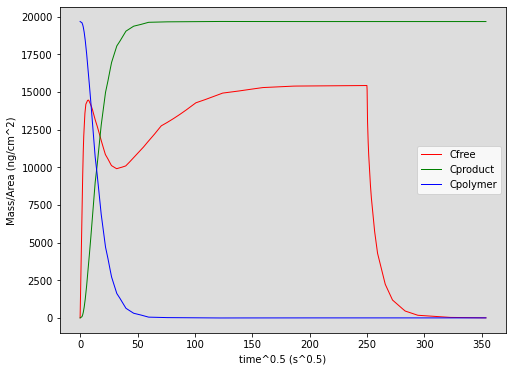

In [4]:
model.mass_uptake_over_time(csv=True, visualization=True, return_value=False)

### Depth Profile

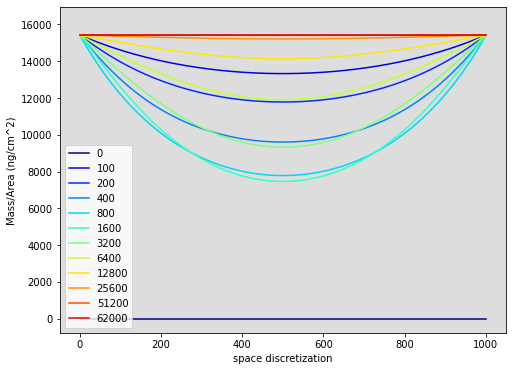

In [5]:
component = 'Cfree' # Cfree/Cproduct/Cpolymer
phase = 'sorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)

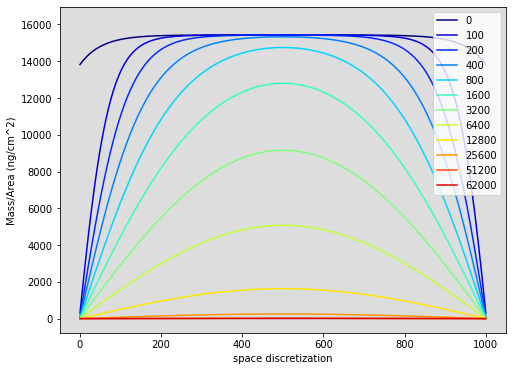

In [6]:
component = 'Cfree' # Cfree/Cproduct/Cpolymer
phase = 'desorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)

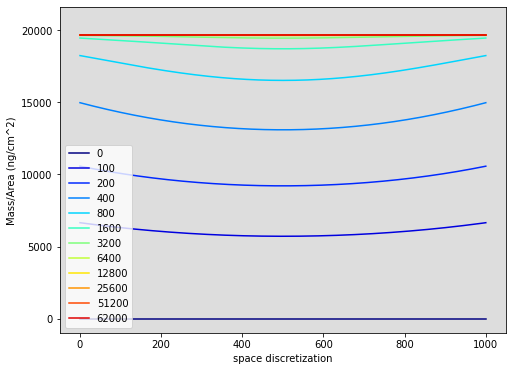

In [7]:
component = 'Cproduct' # Cfree/Cproduct/Cpolymer
phase = 'sorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)

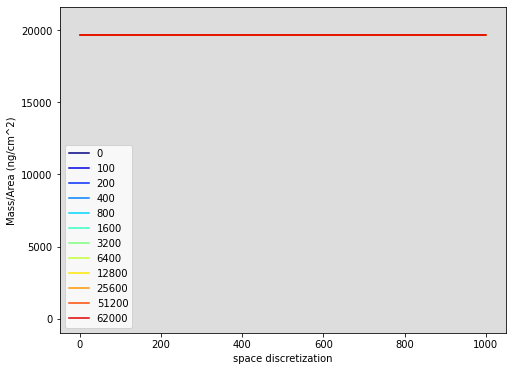

In [8]:
component = 'Cproduct' # Cfree/Cproduct/Cpolymer
phase = 'desorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)

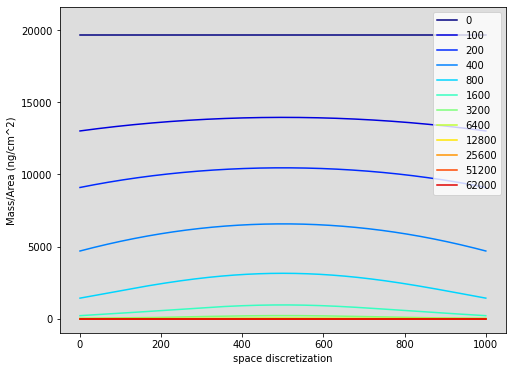

In [9]:
component = 'Cpolymer' # Cfree/Cproduct/Cpolymer
phase = 'sorption'
timepoints = [0,100,200,400,800,1600,3200,6400,12800,25600,51200,62000]
model.depth_profile(component,phase,timepoints,csv=True,visualization=True,return_value=False)

### Appendix

Vapor phase infiltration (VPI) is a process which infiltrates metal-organic vapors into the bulk polymer, hybridizing pure polymeric material into organic-inorganic material with enhanced properties.

According to the VPI reaction-diffusion model, a typical VPI process (one cycle) takes place in 4 steps shown below.

![vpi](img/vpi.png)

a) The polymer is first exposed to the metal-organic precusor, instant equilibrium is reached between the polymer surface and the vapor phase metal-organic pressure. Polymer has inital free volume, and initial diffusivity.

b) When $t>0$, due to chemical potential gradient (surface concentration of metal-organic precursor is higher than bulk), metal-organic precursor will start to diffuse into the bulk of the polymer. Some of the free diffusing metal-organic precursors will react with the polymer functional groups forming immobolized product, others will keep diffusing. The formation of immobolized product will consume polymer free volume, and thus diffusivity decreases during this processes.

c) When $t>>0$, polymer is saturated with both free diffusing precursor and immbolized product. Concentration of free diffusing precusor in the bulk is same as the polymer surface, which is governed by the physical solubility between polymer and metal organic vapor. Concentration of immobolized product is governed by the inital concentration of accessible polymer functional groups and reaction rate.

d) To remove excess amount of metal-organic precursors, vacuum is applied and thus the surface concentration drops to 0. Due to change in chemical potential gradient (now bulk concentration higher than surface), free diffusing species will diffuse out of the polymer, and the immobolized product remains.

With the proposed mechanism, the model can be set up using a set of partial differential equations,

\begin{align}
  \left\{\begin{array}{l}
    \frac{\partial C_{free}}{\partial t} = D\frac{\partial^2 C_{free}}{\partial x^2} - kC_{free}C_{polymer} \\
    \frac{\partial C_{product}}{\partial t} = kC_{free}C_{polymer} \\
    D = D_0 \exp(-K^{\prime}C_{product}) \\
    \frac{\partial C_{polymer}}{\partial t} = -kC_{free}C_{polymer} \\
  \end{array}\right. 
\end{align}

with the following initial and boundary conditions,

\begin{align}
  \left\{\begin{array}{lll}
    C_{free} = 0, & 0 < x < l, & t = 0 \\
    C_{product} = 0, & 0 < x < l, & t = 0 \\
    C_{polymer} = C^{0}_{polymer}, & 0 < x < l, & t = 0 \\
    \frac{\partial C_{free}}{\partial x} = 0, & x = 0, & t > 0 \\
    C_{free} = C^{0}_{surface}, & x = l, & t > 0 \\
  \end{array}\right.
\end{align}

where $C_{free}$ (mol/cm^3) is the concentration of free diffusing vapor, $k$ (cm^3/mol*s) is the reaction rate constant of a second-order reaction, $C_{polymer}$ (mol/cm^3) is the concentration of the accessible reactive polymeric functional groups, $C_{product}$ (mol/cm^3) is the concentration of the immbolized product. $D_{0}$ (cm^2/s) is the initial diffusivity, and $K^{\prime}$ (cm^3/mol) is the hindering constant related to the free volume of the polymer and the molecular size of the penetrant.

Equation 1 combines Fick's second law with a reaction term to describe the process in which the free diffusing precursor diffuses through the polymer film while being consumed by reaction. Equaiton 2 accounts for the rate of formation of immobilized product. Equation 3 assumes that diffusivity decreases exponentially with C_product. Finally Equation 4 captures the rate at which accessible reactive polymer functional groups are formed.